In [63]:
from google.colab import drive
drive.mount('/content/drive')

# Install packages
!pip install faker imbalanced-learn xgboost shap optuna -q

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Clone your repo in Colab
!git clone https://github.com/YOUR_USERNAME/business-analytics-ml.git
%cd business-analytics-ml

# Configure git
!git config --global user.email "asthapankaj2503@gmail.com"
!git config --global user.name "Asthaasu"

Cloning into 'business-analytics-ml'...
fatal: could not read Username for 'https://github.com': No such device or address
[Errno 2] No such file or directory: 'business-analytics-ml'
/content/business-analytics-ml/business-analytics-ml


✓ Packages loaded
Loaded 10000 samples with 21 columns
Churn rate: 11.9%

Features (19):
['days_since_signup', 'contract_is_monthly', 'contract_is_annual', 'has_account_manager', 'is_enterprise', 'age', 'recency_days', 'transaction_count', 'total_spend', 'avg_transaction_value', 'std_transaction_value', 'min_transaction', 'max_transaction', 'engagement_score', 'product_diversity', 'spending_trend', 'ticket_count', 'high_priority_tickets', 'resolution_rate']

Train set: 8000 samples
Test set: 2000 samples
Train churn rate: 11.9%
Test churn rate: 11.8%

Applying SMOTE to handle class imbalance...
Original train set: 8000 samples
Balanced train set: 14102 samples
Balanced churn rate: 50.0%

=== TRAINING BASELINE MODEL ===

Baseline Accuracy: 100.00%

=== HYPERPARAMETER TUNING ===

Trying config 1/4: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200}
  Accuracy: 100.00%, F1: 1.000

Trying config 2/4: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 150}
  Accuracy: 100.00%,

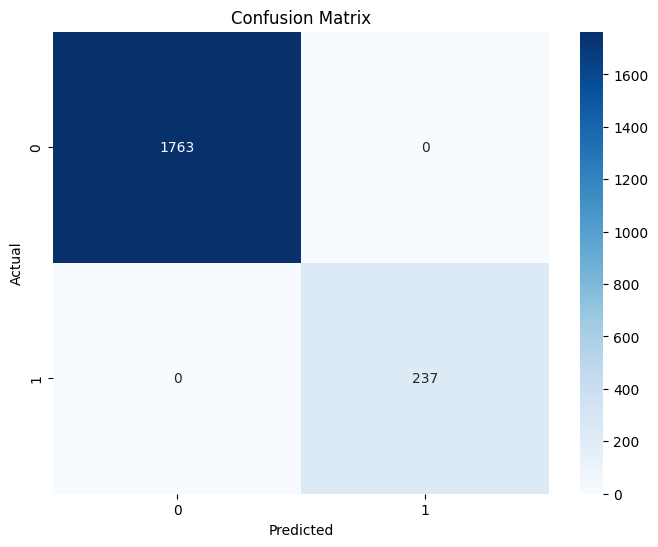


=== FEATURE IMPORTANCE ===

Top 10 Most Important Features:
                  feature  importance
15         spending_trend    0.504897
6            recency_days    0.256441
7       transaction_count    0.140993
13       engagement_score    0.050834
0       days_since_signup    0.029214
10  std_transaction_value    0.011540
11        min_transaction    0.006081
2      contract_is_annual    0.000000
1     contract_is_monthly    0.000000
5                     age    0.000000


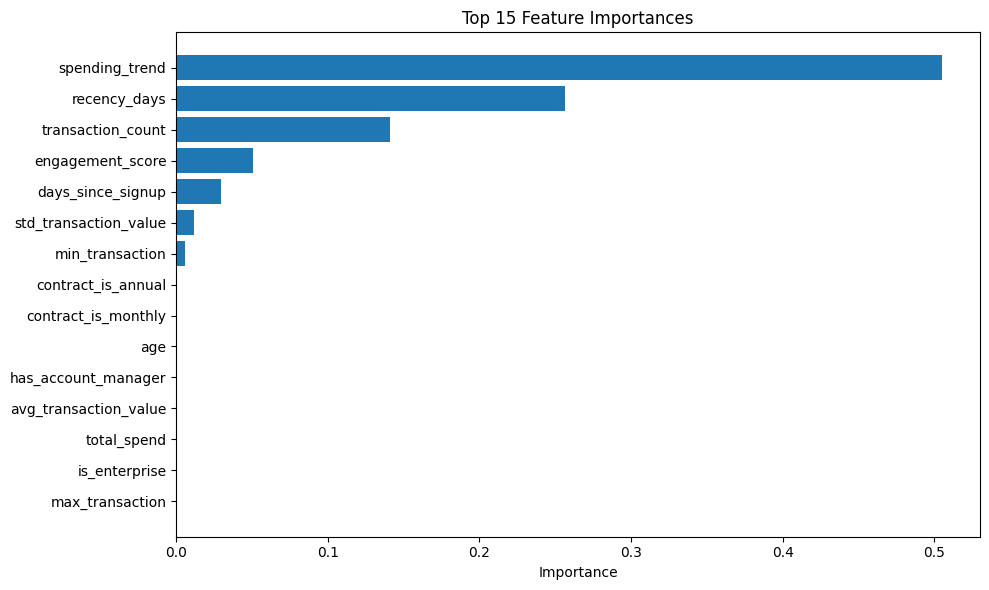


Saving model...
✓ Model saved to models/churn/churn_model.pkl
✓ Feature importance saved

=== CHURN MODEL COMPLETE ===
Final Accuracy: 100.0%
Final F1 Score: 1.000


In [65]:
# ============================================
# CELL 1: Setup
# ============================================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✓ Packages loaded")

# ============================================
# CELL 2: Load Features
# ============================================
features = pd.read_csv('data/processed/features_churn.csv')

print(f"Loaded {len(features)} samples with {len(features.columns)} columns")
print(f"Churn rate: {features['churned'].mean():.1%}")

# ============================================
# CELL 3: Prepare Data
# ============================================
# Separate features and target
X = features.drop(columns=['customer_id', 'churned'])
y = features['churned']

feature_names = X.columns.tolist()
print(f"\nFeatures ({len(feature_names)}):")
print(feature_names)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train churn rate: {y_train.mean():.1%}")
print(f"Test churn rate: {y_test.mean():.1%}")

# ============================================
# CELL 4: Handle Class Imbalance with SMOTE
# ============================================
print("\nApplying SMOTE to handle class imbalance...")

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original train set: {len(X_train)} samples")
print(f"Balanced train set: {len(X_train_balanced)} samples")
print(f"Balanced churn rate: {y_train_balanced.mean():.1%}")

# ============================================
# CELL 5: Train Baseline XGBoost Model
# ============================================
print("\n=== TRAINING BASELINE MODEL ===")

baseline_model = xgb.XGBClassifier(
    max_depth=5,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

baseline_model.fit(X_train_balanced, y_train_balanced)

# Evaluate baseline
y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"\nBaseline Accuracy: {baseline_accuracy:.2%}")

# ============================================
# CELL 6: Hyperparameter Tuning (Manual Grid)
# ============================================
print("\n=== HYPERPARAMETER TUNING ===")

# Try different configurations
configs = [
    {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200},
    {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 150},
    {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 200},
    {'max_depth': 6, 'learning_rate': 0.08, 'n_estimators': 180},
]

best_score = 0
best_params = None
best_model = None

for i, params in enumerate(configs, 1):
    print(f"\nTrying config {i}/{len(configs)}: {params}")

    model = xgb.XGBClassifier(
        **params,
        random_state=42,
        eval_metric='logloss',
        subsample=0.8,
        colsample_bytree=0.8
    )

    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"  Accuracy: {accuracy:.2%}, F1: {f1:.3f}")

    if f1 > best_score:
        best_score = f1
        best_params = params
        best_model = model

print(f"\n✓ Best configuration: {best_params}")
print(f"  Best F1 score: {best_score:.3f}")

# ============================================
# CELL 7: Final Model Evaluation
# ============================================
print("\n=== FINAL MODEL EVALUATION ===")

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAccuracy:  {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1 Score:  {f1:.3f}")
print(f"ROC AUC:   {roc_auc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Active', 'Churned']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('models/churn/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# CELL 8: Feature Importance
# ============================================
print("\n=== FEATURE IMPORTANCE ===")

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('models/churn/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================
# CELL 9: Save Model
# ============================================
print("\nSaving model...")

model_data = {
    'model': best_model,
    'feature_names': feature_names,
    'metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    },
    'params': best_params
}

with open('models/churn/churn_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model saved to models/churn/churn_model.pkl")

# Save feature importance
feature_importance.to_csv('models/churn/feature_importance.csv', index=False)
print("✓ Feature importance saved")

print("\n=== CHURN MODEL COMPLETE ===")
print(f"Final Accuracy: {accuracy:.1%}")
print(f"Final F1 Score: {f1:.3f}")